## Load and clean data
* drop missing values

In [388]:
import pandas as pd
import numpy as np

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

%matplotlib inline

"""The data concerns city-cycle fuel consumption in miles per gallon,
    to be predicted in terms of 3 multivalued discrete and 5 continuous
    attributes." (Quinlan, 1993)"""

df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original",
                header=None, names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
                                      'model', 'origin', 'car_name'], sep='\s+', na_values='?')

df = df.dropna().reset_index(drop=True) # drop 6 rows with missing horsepower
df['horsepower'] = df['horsepower'].astype(float)

# Exclude origin for brevity
training_columns = ['cylinders','displacement','horsepower','weight',
                    'acceleration','model_year']

print(df.shape)
print(df.head(20))

(392, 9)
     mpg  cylinders  displacement  horsepower  weight  acceleration  \
0   18.0          8         307.0       130.0  3504.0          12.0   
1   15.0          8         350.0       165.0  3693.0          11.5   
2   18.0          8         318.0       150.0  3436.0          11.0   
3   16.0          8         304.0       150.0  3433.0          12.0   
4   17.0          8         302.0       140.0  3449.0          10.5   
5   15.0          8         429.0       198.0  4341.0          10.0   
6   14.0          8         454.0       220.0  4354.0           9.0   
7   14.0          8         440.0       215.0  4312.0           8.5   
8   14.0          8         455.0       225.0  4425.0          10.0   
9   15.0          8         390.0       190.0  3850.0           8.5   
10  15.0          8         383.0       170.0  3563.0          10.0   
11  14.0          8         340.0       160.0  3609.0           8.0   
12  15.0          8         400.0       150.0  3761.0           9.5 

## Visualize columns with histograms

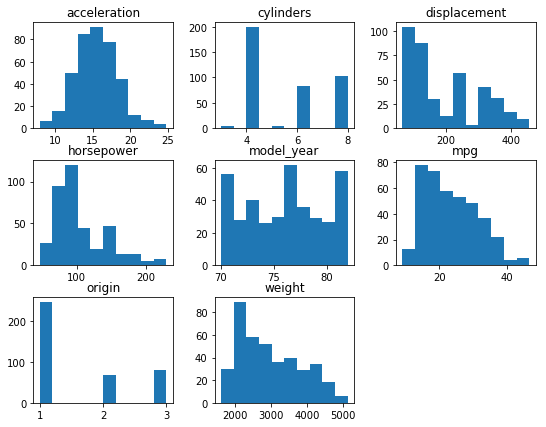

In [342]:
_ = df.hist(bins=10,figsize=(9,7),grid=False)

## Evaluate a simple linear model

In [351]:
X = df[training_columns]
Y = df['mpg']

seed = 3294805

### Grid search for best regularization

In [347]:
lr = Ridge()

alpha_values = np.array([0.25,0.5,1,2,4,8,16])
param_grid = dict(alpha=alpha_values)
kfold = KFold(n_splits=10, random_state=seed)
grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid_result = grid.fit(X, Y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

lr = Ridge(**grid_result.best_params_)

kfold = KFold(n_splits=10, random_state=seed)
scores = cross_val_score(lr, X, Y, cv=kfold, scoring='neg_mean_squared_error')
print('Raw ridge')
print(scores.mean())

Best: -13.362014 using {'alpha': 16.0}
-13.370124 (8.201364) with: {'alpha': 0.25}
-13.369974 (8.201273) with: {'alpha': 0.5}
-13.369678 (8.201097) with: {'alpha': 1.0}
-13.369094 (8.200768) with: {'alpha': 2.0}
-13.367962 (8.200206) with: {'alpha': 4.0}
-13.365831 (8.199430) with: {'alpha': 8.0}
-13.362014 (8.199095) with: {'alpha': 16.0}
Raw ridge
-13.379404023883612


### Scale inputs

In [348]:
scaled_lr = Pipeline([('Scaler', StandardScaler()),('LR', lr)])
scores = cross_val_score(scaled_lr, X, Y, cv=kfold, scoring='neg_mean_squared_error')
print('Scaled ridge')
print(scores.mean())

Scaled ridge
-13.775824354309814


### Evaluation results

The cross-validated mean squared error for linear regression is approximately **13.4**. This will be the baseline.

### Linear model insights

weight: -4.137636
model_year: 2.564799
cylinders: -0.624572
horsepower: -0.622318
displacement: -0.356307
acceleration: -0.103126


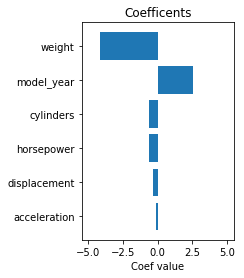

In [396]:
def print_coefs(coefs, training_columns):
    sorted_idx = np.argsort(-abs(coefs)) # negative for descending
    for (name, coef) in zip(np.array(training_columns)[sorted_idx], coefs[sorted_idx]):
        print("%s: %f" % (name, coef))

def plot_coefs(coefs, training_columns, title_suffix=''):
    sorted_idx = np.argsort(abs(coefs))
    pos = np.arange(len(coefs)) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, coefs[sorted_idx], align='center')
    plt.yticks(pos, np.array(training_columns)[sorted_idx])
    plt.xlabel('Coef value')
    plt.title('Coefficents' + title_suffix)
    plt.xlim(-5.5, 5.5)
    plt.show()

# use scaled model
scaled_lr.fit(X, Y)
print_coefs(lr.coef_, training_columns)
plot_coefs(lr.coef_, training_columns)

## Insights

We can see that weight has the most significant impact (heavier means worse mpg). model_year has a positive impact, and the other features, which represent the size and power of the engine, are slightly negative.

## Simple decision tree

In [352]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz

dt = DecisionTreeRegressor()

# Grid search meta parameters
param_grid = dict(min_samples_leaf=np.array([1,5,10,50,100,200]), max_depth=np.array([2,4,6,8,10]))
kfold = KFold(n_splits=10, random_state=seed)
grid = GridSearchCV(estimator=dt, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid_result = grid.fit(X, Y)

# Evaluate best model
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
dt = DecisionTreeRegressor(**grid_result.best_params_)
scores = cross_val_score(dt, X, Y, cv=kfold, scoring='neg_mean_squared_error')
print('CART')
print(scores.mean())

# Serialize tree structure for investigation
dt.fit(X, Y)
output_file = './auto_mpg.graphviz'
export_graphviz(dt, out_file=output_file, feature_names = X.columns)
print("Wrote output to " + output_file)


Best: -11.974432 using {'max_depth': 10, 'min_samples_leaf': 10}
CART
-12.010052711251006
Wrote output to ./auto_mpg.graphviz


### Evaluation results

The cross-validated mean squared error is for our CART tree is approximately **12.0**. This is better than the linear model.

### Insights

The structure of the decision tree suggests that displacement and horsepower are the most important features. This does not agree with what we found from the linear model. 

We can see inefficiencies in the tree model in the fact that the two nodes below the root each split on horsepower, and that the nodes in the layer below that all split on model year. Furthermore, all four second-layer nodes split on almost the same value of model year. This suggests that a model that can use those attributes from the entire dataset (rather than the subpopulation that the tree uses at each node) may have better predictive performance.

However, the fact that the tree model's predictive performance is better than the linear model suggests that there is a significant nonlinear effect.

## Gradient Boosting Trees

Let's also try out a gradient boosting tree model, which often has better predictive performance than any other model.

GBT
-8.736805616265736


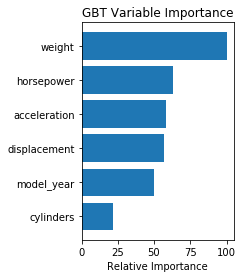

In [404]:
from sklearn.ensemble import GradientBoostingRegressor

scores = cross_val_score(GradientBoostingRegressor(), X, Y, cv=kfold, scoring='neg_mean_squared_error')
print('GBT')
print(scores.mean())

clf = GradientBoostingRegressor()
clf.fit(X, Y)

feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('GBT Variable Importance')
plt.show()


### Evaluation results and insights

The cross-validated mean squared error from GBT is approximately **8.8**. This is much better than linear regression or our simple decision tree. 

GBT's variable importance attribute tells us that weight is the most important feature, followed by acceleration, horsepower, displacement, and model_year, which are all similar. Unfortunately, GBT does not tell us anything about the numerical magnitude or sign of their impact, nor relationship of these features.

## Linear model tree

In [392]:
import sys
sys.path.append('/Users/logan/ws/price-modeling/python/')

from lmt import LinearModelTree
from sklearn.metrics import mean_squared_error

X = df[training_columns]

shared_scaler = StandardScaler()
shared_scaler.fit(X)

def fit_linear_model(x, y):
    lr = Ridge()
    lr.fit(shared_scaler.transform(x), y)
    return SharedScalerModel(shared_scaler, lr)

class SharedScalerModel:
    
    def __init__(self, scaler, lm):
        self.scaler = scaler
        self.lm = lm
        self.coef_ = lm.coef_
        self.intercept_ = lm.intercept_
        
    def predict(self, X):
        return self.lm.predict(self.scaler.transform(X))


MIN_NODE_SIZE = 100
MIN_SPLIT_IMPROVEMENT = 10
lmt = LinearModelTree(MIN_NODE_SIZE, fit_linear_model, min_split_improvement=MIN_SPLIT_IMPROVEMENT)

kfold = KFold(n_splits=10, random_state=seed)
scores = []
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    lmt.build_tree(X_train.values, X_train, y_train.values)
    y_pred = lmt.predict(X_test.values, X_test)
    mse = mean_squared_error(y_test, y_pred)
    scores.append(mse)

print(np.array(scores).mean())


8.943056984982718


### Evaluation results

[Optimal meta parameters found via grid search, not shown]

The LMT gives a cross-validated mean squared error of approximately **8.9**, which is nearly as good as GBT, and much better than our linear regression and simple decision tree models.

### Insights

In [369]:
# Build a tree on the full dataset, and serialize it to see the feature splits
lmt = LinearModelTree(MIN_NODE_SIZE, fit_linear_model, MIN_SPLIT_IMPROVEMENT)
lmt.build_tree(X.values, X, Y.values)
print(lmt.serialize())


T,rc:392,f:2,v:78.0
TL,rc:104,f:_,v:_ 
TR,rc:288,f:2,v:97.0
TRL,rc:110,f:_,v:_ 
TRR,rc:178,f:_,v:_ 


In [357]:
print(X.columns[2])

horsepower


### Tree structure

The linear model tree produces just 2 splits, for a total of 3 leaf nodes. It splits first at horsepower = 78, and for horsepower >= 78 it splits at horsepower = 97. We will call the three subpopulations low power, medium power, and high power.

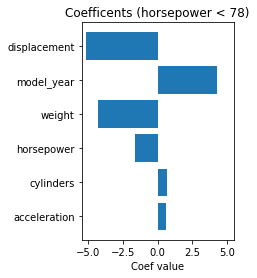

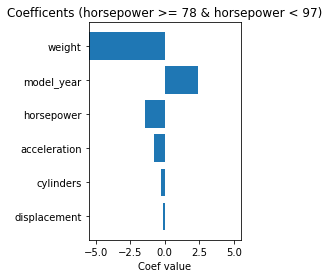

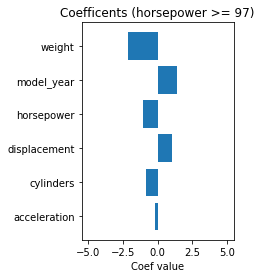

displacement: -5.186292
model_year: 4.287827
weight: -4.287711
horsepower: -1.605432
cylinders: 0.685287
acceleration: 0.608814

weight: -5.522914
model_year: 2.410542
horsepower: -1.416881
acceleration: -0.805342
cylinders: -0.311572
displacement: -0.156405

weight: -2.154847
model_year: 1.428982
horsepower: -1.089580
displacement: 1.041145
cylinders: -0.867039
acceleration: -0.200428


In [397]:
root_lm = lmt.root.lm
node_1_coef = root_lm.coef_ + lmt.root.left.lm.coef_
plot_coefs(node_1_coef, training_columns, ' (horsepower < 78)')

right_coef = lmt.root.right.lm.coef_
node_2_coef = root_lm.coef_ + right_coef + lmt.root.right.left.lm.coef_
plot_coefs(node_2_coef, training_columns, ' (horsepower >= 78 & horsepower < 97)')


node_3_coef = root_lm.coef_ + right_coef + lmt.root.right.right.lm.coef_
plot_coefs(node_3_coef, training_columns, ' (horsepower >= 97)')


print_coefs(node_1_coef, training_columns)
print('')
print_coefs(node_2_coef, training_columns)
print('')
print_coefs(node_3_coef, training_columns)

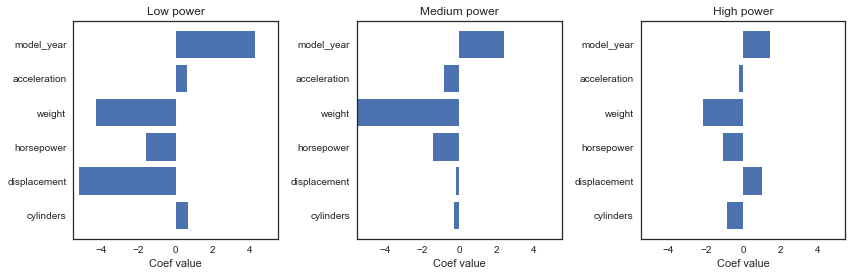

In [430]:
rows = 1
cols = 3
coefs = [
    node_1_coef,
    node_2_coef,
    node_3_coef,
]
titles = ['Low power', 'Medium power', 'High power']
f, axs = plt.subplots(rows, cols, sharex='col', figsize=(12, 4))
for col in range(cols):
    pos = np.arange(len(coefs[col])) + .5
    axs[col].barh(pos, coefs[col], align='center')
    axs[col].set_yticks(pos)
    axs[col].set_yticklabels(np.array(training_columns))
    axs[col].set_xlabel('Coef value')
    axs[col].set_title(titles[col])
    axs[col].set_xlim(-5.5, 5.5)

f.tight_layout()



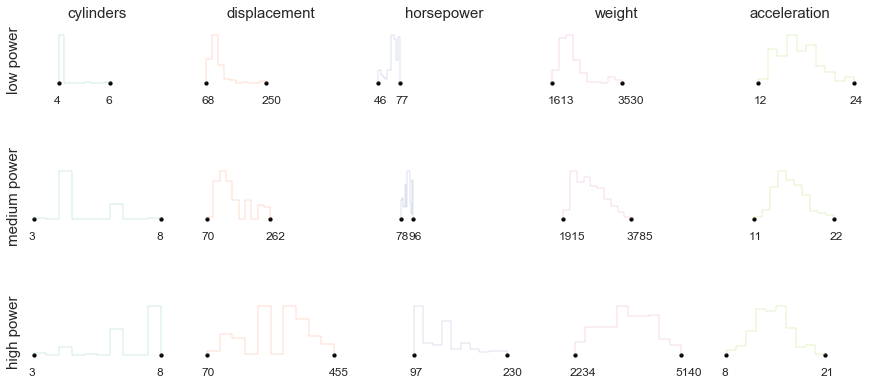

In [434]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

def gen(n=40):
    return np.random.normal(size=n)

rows, cols = 3, 5

fsize = 15

rownames = ['low power', 'medium power', 'high power']
subpop_data = [
    df.query('horsepower < 78'),
    df.query('horsepower >= 78 & horsepower < 97'),
    df.query('horsepower >= 97'),
]

cmap = sns.color_palette("Set2", cols)

f, axs = plt.subplots(rows, cols, sharex='col', figsize=(15, 6))

for i in range(rows):
    for j in range(cols):
        _ = axs[i,j].hist(subpop_data[i][training_columns[j]], histtype='step', color=cmap[j])
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        left, right = _[1][0], _[1][-1]
        
        # black dots
        axs[i,j].scatter(left, 0, c='black', s=15)
        axs[i,j].scatter(right, 0, c='black', s=15)
        
        # min,max annotations
        axs[i,j].annotate(str(int(left)), 
                          xy=(left, 0), 
                          xytext=(-5, -20),
                          textcoords='offset points')
        
        axs[i,j].annotate(str(int(right)), 
                          xy=(right, 0), 
                          xytext=(-5, -20),
                          textcoords='offset points')
        
        if i == 0:
            axs[i,j].set_xlabel(training_columns[j], labelpad=15, size=fsize)
            axs[i,j].xaxis.set_label_position('top')
            
        if j == 0:
            axs[i,j].set_ylabel(rownames[i], size=fsize)

f.subplots_adjust(hspace=1.5)
sns.despine(left=True, bottom=True)

Inspecting the weights from the linear model tree gives us a very different understanding of what affects fuel efficiency than we got from the other models. While there are some commonalities across the different subpopulations that our LMT has identified, we also see some significant differences.

For all vehicles, weight has a large negative impact, which makes sense because fuel economy should get worse with the more mass the vehicle has to move. Model year has a large positive impact for all vehicles; presumably engine technology improved significantly in this period. These are similar to what we see in the single linear model. However, the magnitude of those impacts changes across the subpopulations that our LMT has identified, and engine size and power have different magnitudes of effect in different subpopulations.

For low-power vehicles, model year has a huge positive impact, and we see that in this population fuel economy is very sensitive to engine displacement.

In the medium-power category, weight again has a huge negative impact but fuel economy only increases moderately with model year.

For vehicles with high-power, weight has as much less significant impact, and the same can be said for model year. The engine size and power features are more relevant in this population by comparison to weight and model year. In this population the engine sizes are far more variable than in the other populations, so engine size ends up having a larger impact on the prediction than even what the coefficients tell us.